In [1]:
import cobra
from cobra.io import load_json_model, save_json_model
from cobra import Model, Reaction, Metabolite
import numpy as np
from math import exp
import pandas as pd
from matplotlib import pyplot as plt
from fba_functions import *

In [2]:
ipsc_core = load_json_model('../data/gems/iPSC_core.json')

In [3]:
Adata = pd.read_csv('../data/gems/EnzymeActivity.csv')
A_dict = {Adata['Rxn'][i]:Adata['Activity(mmol/hr/g)'][i] for i in range(len(Adata.index))}

In [4]:
print(ipsc_core.medium.keys())

dict_keys(['EX_glc__D_e', 'EX_h_e', 'EX_pi_e', 'EX_o2_e', 'EX_h2o_e', 'EX_chol_e', 'EX_hco3_e', 'EX_na1_e', 'EX_hxan_e', 'EX_so4_e', 'EX_asn__L_e', 'EX_cys__L_e', 'EX_gln__L_e', 'EX_lys__L_e', 'EX_pro__L_e', 'EX_tyr__L_e', 'EX_met__L_e', 'EX_leu__L_e', 'EX_ser__L_e', 'EX_his__L_e', 'EX_thr__L_e', 'EX_phe__L_e', 'EX_arg__L_e', 'EX_ile__L_e', 'EX_val__L_e', 'EX_trp__L_e', 'EX_asp__L_e', 'EX_k_e', 'EX_ala__L_e', 'EX_glu__L_e', 'EX_gly_e'])


In [5]:
ex_aa_list = ['EX_asn__L_e', 'EX_cys__L_e', 'EX_gln__L_e', 'EX_lys__L_e', 'EX_pro__L_e', 
              'EX_tyr__L_e', 'EX_met__L_e', 'EX_leu__L_e', 'EX_ser__L_e', 'EX_his__L_e', 
              'EX_thr__L_e', 'EX_phe__L_e', 'EX_arg__L_e', 'EX_ile__L_e', 'EX_val__L_e', 
              'EX_trp__L_e', 'EX_asp__L_e', 'EX_ala__L_e', 'EX_glu__L_e', 'EX_gly_e']
def set_PA(model, ptot, A_dict):
    sigma=0.5
    t_sector = model.reactions.EX_lac__L_e.flux_expression/(sigma*A_dict['EX_lac__L_e']) +\
           (-1)*model.reactions.EX_glc__D_e.flux_expression/A_dict['EX_glc__D_e'] +\
             model.reactions.EX_ac_e.flux_expression/(sigma*A_dict['EX_ac_e'])
    for ex_aa in ex_aa_list:
        if ex_aa != 'EX_ala__L_e':
            t_sector = t_sector + (-1)*model.reactions.get_by_id(ex_aa).flux_expression/A_dict['EX_aa_e']
    a_sector = model.reactions.BIOMASS.flux_expression/A_dict['BIOMASS']
    ngam_sector = model.reactions.ATPM.flux_expression/A_dict['ATPM']
    c_sector = model.reactions.ENO.flux_expression/(sigma*A_dict['ENO'])
    for k in A_dict.keys():
        if k not in ['ENO','EX_lac__L_e', 'EX_ac_e','EX_glc__D_e','EX_aa_e','ATPM','BIOMASS']:
            c_sector  = c_sector  + model.reactions.get_by_id(k).flux_expression/(sigma*A_dict[k])
    PA = model.problem.Constraint( expression = a_sector + c_sector + ngam_sector,
                        name = 'PA', lb= 0, ub = ptot)
    model.add_cons_vars([ PA ])
    return None

In [7]:
ptot = 0.67366; NGAM_0 = 2.2771;
with ipsc_core:
    for ex_aa in ex_aa_list:
        ipsc_core.reactions.get_by_id(ex_aa).lower_bound=-0.28
    ipsc_core.reactions.EX_glc__D_e.lower_bound=-1.07
    ipsc_core.reactions.ATPM.lower_bound = 3.5
    # Proteome constraints
    set_PA(ipsc_core, ptot, A_dict)
    fluxes = cobra.flux_analysis.pfba(ipsc_core).fluxes
    uptake_flux = ipsc_core.summary().uptake_flux
    secretion_flux = ipsc_core.summary().secretion_flux
    print(ipsc_core.summary())

Objective
1.0 BIOMASS = 0.00398588827540383

Uptake
------
Metabolite    Reaction      Flux  C-Number C-Flux
  arg__L_e EX_arg__L_e  0.001113         6  0.09%
  asn__L_e EX_asn__L_e  0.000782         4  0.04%
    chol_e   EX_chol_e 0.0006041         5  0.04%
  cys__L_e EX_cys__L_e 0.0003104         3  0.01%
  glc__D_e EX_glc__D_e      1.07         6 85.01%
  gln__L_e EX_gln__L_e    0.2092         5 13.85%
     gly_e    EX_gly_e  0.001514         2  0.04%
    hco3_e   EX_hco3_e 0.0002215         1  0.00%
  his__L_e EX_his__L_e 0.0004217         6  0.03%
    hxan_e   EX_hxan_e 0.0002268         5  0.02%
  ile__L_e EX_ile__L_e  0.001038         6  0.08%
  leu__L_e EX_leu__L_e  0.001797         6  0.14%
  lys__L_e EX_lys__L_e  0.001632         6  0.13%
  met__L_e EX_met__L_e 0.0005414         5  0.04%
      o2_e     EX_o2_e    0.3534         0  0.00%
  phe__L_e EX_phe__L_e 0.0007901         9  0.09%
      pi_e     EX_pi_e   0.02789         0  0.00%
  pro__L_e EX_pro__L_e  0.000978         

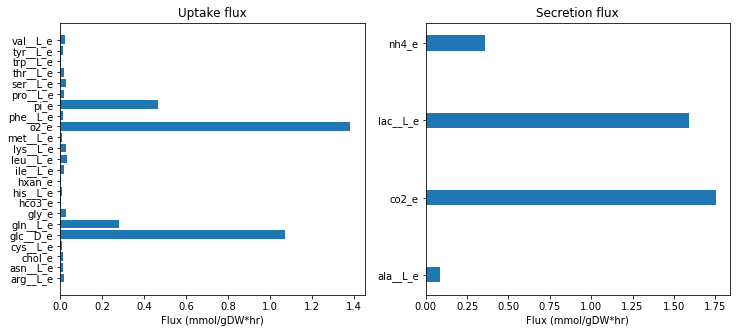

In [36]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
secretion_flux = secretion_flux[(secretion_flux.flux!=0) & ~(secretion_flux.reaction.isin(['EX_h2o_e','EX_h_e']) )]
uptake_flux = uptake_flux[uptake_flux.flux!=0]
axs[0].barh(uptake_flux.metabolite,uptake_flux.flux)
axs[1].barh(secretion_flux.metabolite,-1*secretion_flux.flux, height=0.2)
axs[0].set_title('Uptake flux')
axs[1].set_title('Secretion flux')
for ax in axs:
    ax.set_xlabel('Flux (mmol/gDW*hr)')

In [20]:
A_ATPMs = np.linspace(5.65,5.69,num=30); grs=[]
ptot = 0.67366; NGAM = 2.2771; 
for A_value in A_ATPMs:
    temp_A_dict = A_dict.copy()
    temp_A_dict['ATPM']=A_value
    fluxes = pcfba(ipsc_core, ptot, NGAM, 0.28, 1.07,2.6,temp_A_dict)
    grs.append(fluxes['BIOMASS'])

In [24]:
grs.index(0.06635456904096668)
A_ATPMs[19]

5.676206896551725

Text(5.655, 0.06645, 'Activity of NGAM=5.6762')

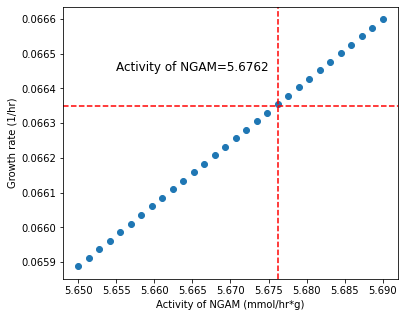

In [27]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.scatter(A_ATPMs,grs)
ax.axvline(x=5.6762,color='r',ls='--')
ax.axhline(y=0.06635,color='r',ls='--')
ax.set_xlabel('Activity of NGAM (mmol/hr*g)')
ax.set_ylabel('Growth rate (1/hr)')
ax.text(5.655,0.06645,s='Activity of NGAM=5.6762',fontsize=12)